In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

In [2]:
from tdse.prop.propagator import Time_Indep_Hamil_Propagator

In [3]:
# from numbers import Integral

# import numpy as np

# from tdse.evol import get_D2_tridiag, get_M2_tridiag, mul_tridiag_and_diag
# from tdse.tridiag import tridiag_forward, tridiag_backward

# class Time_Indep_Hamil_Propagator(object):
#     """A Propagator for a time-independent Hamiltonian"""
    
#     def __init__(self, N, dx, Vx, hbar=1.0, m=1.0):
        
#         # Check arguments
#         if not isinstance(N, Integral) or not (N > 0):
#             _msg = "`N` should be a positive integer. Given: {}"
#             raise TypeError(_msg.format(N))
#         self.N = N
        
#         if not (dx > 0):
#             _msg = "`dx` should be positive. Given: {}"
#             raise TypeError(_msg.format(dx))
#         self.dx = dx
            
#         try: _Vx = np.array(Vx, copy=False)
#         except:
#             _msg = "Failed to convert the given potential array: `Vx`"
#             raise Exception(_msg.format(Vx))
#         if _Vx.shape != (N,):
#             _msg = ("The potential array should have shape (N,)==({},)\n"
#                     "Given: {}")
#             raise TypeError(_msg.format(N, Vx))
#         self.Vx = _Vx
        
#         if not (hbar > 0.0) or not (m > 0.0):
#             _msg = ("hbar and m (mass) should be positive\n"
#                     "Given hbar = {}, m = {}")
#             raise TypeError(_msg.format(hbar, m))
#         self.hbar, self.m = hbar, m
        
#         # Construct tridiagonals for propagation
#         self.M2 = get_M2_tridiag(self.N)
#         self.D2 = get_D2_tridiag(self.N, self.dx)
#         _M2V = mul_tridiag_and_diag(self.M2, self.Vx)
#         self.M2H = -0.5*self.hbar**2/self.m * self.D2 + _M2V
        
        
#     def propagate(self, sf_arr, dt, Nt=1):
#         """Propagate the given state function by the given time interval"""
#         assert isinstance(sf_arr, np.ndarray) and sf_arr.dtype == np.complex
#         _sf_at_mid_time = np.empty_like(sf_arr)
#         _U = self.M2 - 0.5j*dt*self.M2H
#         _U_adj = self.M2 + 0.5j*dt*self.M2H
#         for _ in range(Nt):
#             tridiag_forward(_U, sf_arr, _sf_at_mid_time)
#             tridiag_backward(_U_adj, sf_arr, _sf_at_mid_time)

In [4]:
Nx = 101
x_total_arr = np.linspace(0, 10.0, Nx+2)
x_arr = x_total_arr[1:-1]
Vx = np.full_like(x_arr, 0.0, dtype=float)
dx = x_arr[1] - x_arr[0]

In [5]:
t0 = 0.0
sf_t0_arr = np.sin(pi/10.0*x_arr) + 0.6*np.sin(2*pi/10.0*x_arr)

In [6]:
prop = Time_Indep_Hamil_Propagator(Nx, dx, Vx)

# Animate

In [7]:
from matplotlib.animation import FuncAnimation

%matplotlib notebook

<IPython.core.display.Javascript object>


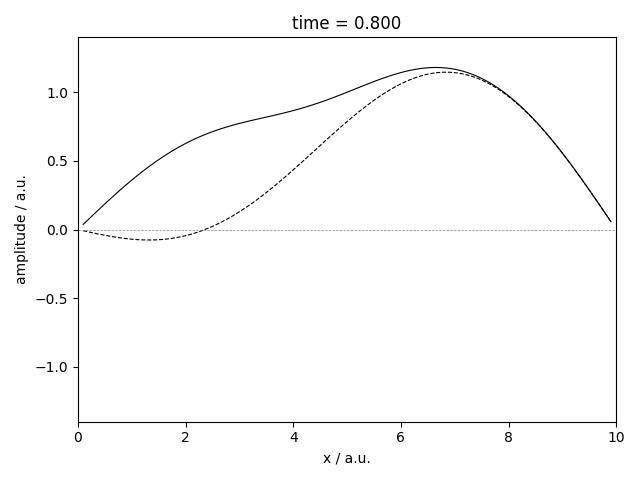

In [8]:
fig, ax = plt.subplots()

ax.set_xlim(x_total_arr[[0,-1]]), ax.set_ylim(-1.4,1.4)
ax.set_xlabel("x / a.u."), ax.set_ylabel("amplitude / a.u.")
title_form = "time = {:.3f}"
ax.set_title(title_form)

l, = ax.plot([],[],'--',linewidth=0.8,color='black')
l_env, = ax.plot([],[],linewidth=0.8,color=l.get_color())
ax.plot(ax.get_xlim(), [0,0], '--',linewidth=0.5, color='gray')

fig.tight_layout()

dt = 0.1
sf_arr = np.empty_like(x_arr, dtype=complex)

def init():
    sf_arr[:] = sf_t0_arr

def update(i):
    ax.set_title(title_form.format(t0+i*dt))
    prop.propagate(sf_arr, dt, Nt=15)
    l.set_data(x_arr, sf_arr.real)
    l_env.set_data(x_arr, np.abs(sf_arr))

ani = FuncAnimation(fig, update, frames=30, init_func=init)

In [9]:
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=5)
# ani.save("ani-test-3.gif", writer=writer)